In [49]:
# Prerequisites for pomagranate
!apt-get -qq install python3-dev graphviz libgraphviz-dev pkg-config
!pip -qq install pomegranate
!pip -qq install matplotlib pygraphviz numpy

In [50]:
# Imports
from pomegranate import *
import tempfile
import pygraphviz
import matplotlib.pyplot as plt
import matplotlib.image
import random
import numpy as np

### Modelling

In [51]:
# States
travel = DiscreteDistribution({'T': 5./100, 'F': 95./100})
owns_device = DiscreteDistribution({'T': 70./100, 'F': 30./100})
foreign_purchase = ConditionalProbabilityTable(
    [['T', 'T', 88./100],
     ['T', 'F', 12./100],
     ['F', 'T', 0.0001],
     ['F', 'F', 0.9999],], [travel])
online_purchase = ConditionalProbabilityTable(
    [['T', 'T', 40./100],
     ['T', 'F', 60./100],
     ['F', 'T', 5./100],
     ['F', 'F', 95./100],], [owns_device])
fraud = ConditionalProbabilityTable(
    [['T', 'T', 'T', 99.995],
     ['T', 'T', 'F', 0.005],
     ['T', 'F', 'T', 85./100],
     ['T', 'F', 'F', 15./100],
     ['F', 'T', 'T', 80./100],
     ['F', 'T', 'F', 20./100],
     ['F', 'F', 'T', 75./100],
     ['F', 'F', 'F', 25./100],], [travel, online_purchase])

# Setup model nodes
s1 = Node(travel, name="travel")
s2 = Node(owns_device, name="owns_device")
s3 = Node(foreign_purchase, name="foreign_purchase")
s4 = Node(online_purchase, name="online_purchase")
s5 = Node(fraud, name="fraud")

# Setup model
model = BayesianNetwork("CC Fraud Detection")
model.add_states(s1, s2, s3, s4, s5)
model.add_edge(s1, s3)
model.add_edge(s2, s4)
model.add_edge(s1, s5)
model.add_edge(s4, s5)
model.bake()

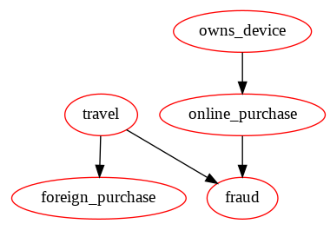

In [52]:
def plot(model):
    G = pygraphviz.AGraph(directed=True)

    for state in model.states:
        G.add_node(state.name, color='red')

    for parent, child in model.edges:
        G.add_edge(parent.name, child.name)

    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = matplotlib.image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')

# Plot dependency graph of model
plot(model)

### Inference

We will use Gibbs sampling method

In [53]:
## initializing the CPTs given in the bayesian network
P_T = np.array((95./100 , 5./100))
P_OD = np.array((30./100 , 70./100))
P_FP_g_T = np.array(((99.99/100 , 0.01/100) , (12.0/100 , 88.0/100)))
P_OP_g_OD = np.array(((95.0/100 , 5./100) , (60.0/100 , 40.0/100)))
P_FR_g_T_OP = np.array((((25./100 , 75./100) , (20./100 , 80./100)) , ((15.0/100 , 85./100) , (0.5/100 , 99.5/100))))

## markov blanket of fraud is travel and online purchase
def FR_given_others (t_ , op_) :
  ## P(FR | t , op)
  return P_FR_g_T_OP[t_][op_]

## markov blanket of foreign-purchase is travel
def FP_given_others(t_) :
  ## P(FP | T)
  return P_FP_g_T[t_]

## markov blanket of travel is foreign-purchase , fraud ,  online-purchase
def T_given_others (fp_ , fr_ ,  op_):
  ## P(T | FP , FR , OP) = alpha P(T) * P(FP | T) * P(FR | T , OP)
  return P_T * ((P_FP_g_T[0][fp_] , P_FP_g_T[1][fp_])) * ((P_FR_g_T_OP[0][op_][fr_] , P_FR_g_T_OP[1][op_][fr_])) 

## markov blanket of owns-device is online_purchase
def OD_given_others(op_) :
  ## P(OD | OP) = alpha * P(OD) * P(OP | OD)
  return P_OD * (P_OP_g_OD[0][op_] , P_OP_g_OD[1][op_])

## markov blanket of online-purchase is fraud , travel , ownsdevice
def OP_given_others(fr_ , t_ , od_) :
  ## P(OP | FR , T , OD) = alpha * P(OP | OD) * P(FR | T , OP)
  return P_OP_g_OD[od_] * ((P_FR_g_T_OP[t_][0][od_] , P_FR_g_T_OP[t_][1][od_]))

In [54]:
def get_sample(prob):
    x = random.uniform(0, 1)
    if x <= prob :
        return 'T'
    else:
        return 'F'

def get_prob_var(var, evidence, sample):
    # Formula : P(X) = normalize( P( X | Parents(X) ) * ( for Y in Children(X) multiply: P( Y | Parents(Y) ) ) )

    # Combine all evidence of known and unknown variables
    all_evidence = {}
    for key in evidence.keys():
        if evidence[key] == 'T':
            all_evidence[key] = 1
        if evidence[key] == 'F':
            all_evidence[key] = 0
    
    for key in sample.keys():
        if sample[key] == 'T':
            all_evidence[key] = 1
        if sample[key] == 'F':
            all_evidence[key] = 0

    # All probabilities
    # Re-initializing as pomegranate does not provide easy access from model
    T_cpt = np.array((95./100 , 5./100))
    OD_cpt = np.array((30./100 , 70./100))
    FP_cpt_T = np.array(((99.99/100 , 0.01/100) , (12.0/100 , 88.0/100)))
    OP_cpt_OD = np.array(((95.0/100 , 5./100) , (60.0/100 , 40.0/100)))
    F_cpt_T_OP = np.array((((25./100 , 75./100) , (20./100 , 80./100)) , ((15.0/100 , 85./100) , (0.5/100 , 99.5/100))))

    # Get 'No' and 'Yes' probability (prob_F, prob_T) of var variable
    if var == 'owns_device':
        # ans = alpha x P(OD) x P(OP | OD)
        op = all_evidence['online_purchase']
        (prob_F, prob_T) = OD_cpt * (OP_cpt_OD[0][op] , OP_cpt_OD[1][op])
    
    elif var == 'foreign_purchase':
        # ans = alpha x P(FP | T)
        t = all_evidence['travel']
        (prob_F, prob_T) = FP_cpt_T[t]
    
    elif var == 'online_purchase':
        # ans = alpha x P(OP | OD) x P(F | OP, T)
        t = all_evidence['travel']
        f = all_evidence['fraud']
        od = all_evidence['owns_device']
        (prob_F, prob_T) = OP_cpt_OD[od] * ((F_cpt_T_OP[t][0][od] , F_cpt_T_OP[t][1][od]))
    
    elif var == 'travel':
        # ans = alpha x P(T) x P(FP | T) x P(F | OP, T)
        fp = all_evidence['foreign_purchase']
        f = all_evidence['fraud']
        op = all_evidence['online_purchase']
        (prob_F, prob_T) = T_cpt * ((FP_cpt_T[0][fp] , FP_cpt_T[1][fp])) * ((F_cpt_T_OP[0][op][f] , F_cpt_T_OP[1][op][f]))

    elif var == 'fraud':
        # ans = alpha x P(F | OP, T)
        op = all_evidence['online_purchase']
        t = all_evidence['travel']
        (prob_F, prob_T) = F_cpt_T_OP[t][op]
    
    else:
        print(var)
        raise ValueError("what?!")
    
    # Normalize and return
    return ( prob_T/(prob_T + prob_F) )

def gibbs(model, evidence, iterations = 10000):
    known_variables = [var for var in evidence.keys() if evidence[var] != 'hidden']
    print(f"Known variables are: {known_variables}")

    unknown_variables = [var for var in evidence.keys() if evidence[var] == 'hidden']
    print(f"Unknown variables are: {unknown_variables}")

    # Initially set all hidden variables to true (T)
    sample = { var : 'T' for var in unknown_variables }
    print(f"Initial sample is: {sample}")

    samples = []

    for _ in range(iterations):
        for var in unknown_variables:
            # Get probability of random variable given all other variables
            prob_var = get_prob_var(var, evidence, sample)

            # Sample random variable on probability computed
            updated_var_val = get_sample(prob_var)

            # Update value of random variable
            sample[var] = updated_var_val
        
        # Append this sample to list of all samples
        # At the end of this iteration
        samples.append(sample.copy())

    # Return samples from all iterations
    return samples

In [55]:
# (a) Prior probability of fraudulent transaction
print("Query (a) \n=========")
evidence = { 
    'travel' : 'hidden',
    'owns_device' : 'hidden',
    'foreign_purchase' : 'hidden',
    'online_purchase' : 'hidden',
    'fraud' : 'hidden'
    }

samples = gibbs(model, evidence)
print(f"{len(samples)} samples returned:\n\t{samples[:5]}")

# Compute probability of fraud from Gibbs samples
count_fraud = 0
for sample in samples:
    if sample['fraud'] == 'T':
        count_fraud += 1
print(f"Counts of fraud in all samples: {count_fraud}")

prob_fraud = count_fraud / len(samples)
print(f"Probability of fraud payment: {prob_fraud}")

Query (a) 
Known variables are: []
Unknown variables are: ['travel', 'owns_device', 'foreign_purchase', 'online_purchase', 'fraud']
Initial sample is: {'travel': 'T', 'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}
10000 samples returned:
	[{'travel': 'T', 'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}, {'travel': 'T', 'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}, {'travel': 'T', 'owns_device': 'F', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}, {'travel': 'T', 'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}, {'travel': 'T', 'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}]
Counts of fraud in all samples: 7751
Probability of fraud payment: 0.7751


In [56]:
# (b) Probability of fraudulent transaction given user owns smartphone
print("Query (b) \n=========")
evidence = { 
    'travel' : 'hidden',
    'owns_device' : 'T',
    'foreign_purchase' : 'hidden',
    'online_purchase' : 'hidden',
    'fraud' : 'hidden'
    }

samples = gibbs(model, evidence)
print(f"{len(samples)} samples returned:\n\t{samples[:5]}")

# Compute probability of fraud from Gibbs samples
count_fraud = 0
for sample in samples:
    if sample['fraud'] == 'T':
        count_fraud += 1
print(f"Counts of fraud in all samples: {count_fraud}")

prob_fraud = count_fraud / len(samples)
print(f"Probability of fraud payment: {prob_fraud}")

Query (b) 
Known variables are: ['owns_device']
Unknown variables are: ['travel', 'foreign_purchase', 'online_purchase', 'fraud']
Initial sample is: {'travel': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}
10000 samples returned:
	[{'travel': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}, {'travel': 'T', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}, {'travel': 'T', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}, {'travel': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}, {'travel': 'T', 'foreign_purchase': 'F', 'online_purchase': 'F', 'fraud': 'T'}]
Counts of fraud in all samples: 7804
Probability of fraud payment: 0.7804


In [57]:
# (c) Probability of fraudulent transaction given user is abroad
print("Query (c) \n=========")
evidence = { 
    'travel' : 'T',
    'owns_device' : 'hidden',
    'foreign_purchase' : 'hidden',
    'online_purchase' : 'hidden',
    'fraud' : 'hidden'
    }

samples = gibbs(model, evidence)
print(f"{len(samples)} samples returned:\n\t{samples[:5]}")

# Compute probability of fraud from Gibbs samples
count_fraud = 0
for sample in samples:
    if sample['fraud'] == 'T':
        count_fraud += 1
print(f"Counts of fraud in all samples: {count_fraud}")

prob_fraud = count_fraud / len(samples)
print(f"Probability of fraud payment: {prob_fraud}")

Query (c) 
Known variables are: ['travel']
Unknown variables are: ['owns_device', 'foreign_purchase', 'online_purchase', 'fraud']
Initial sample is: {'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}
10000 samples returned:
	[{'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}, {'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}, {'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}, {'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'T', 'fraud': 'T'}, {'owns_device': 'T', 'foreign_purchase': 'T', 'online_purchase': 'F', 'fraud': 'T'}]
Counts of fraud in all samples: 8960
Probability of fraud payment: 0.896
